<a href="https://colab.research.google.com/github/NousForFreedom/NSL_5/blob/main/NSL_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import**

In [ ]:
pip install graphviz

In [ ]:
pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as keras
import pickle
import time
!pip install scikit-learn
#visualization
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import graphviz
import seaborn as sns
from pandas.plotting import scatter_matrix

#preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MultiLabelBinarizer

# Oversampling
from imblearn.over_sampling import SMOTE

# PCA
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

# Models
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC, OneClassSVM
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import reciprocal, uniform

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from xgboost import plot_importance
from xgboost import XGBRegressor

# Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics.pairwise import rbf_kernel

# Keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam


# **Functions**

In [ ]:
# draw histogram
def draw_hist(dataset) :
  dataset.hist(bins=50, figsize=(20,15))
  plt.show()

In [ ]:
# dataset split
def get_train_val_test(train, validation, test):
    x_train, y_train = train.drop(['attack_cat', 'attack_type', 'difficulty_level'], axis=1), train['attack_cat']
    x_validation, y_validation = validation.drop(['attack_cat', 'attack_type', 'difficulty_level'], axis=1), validation['attack_cat']
    x_test, y_test = test.drop(['attack_cat', 'attack_type', 'difficulty_level'], axis=1), test['attack_cat']

    x_train = pd.get_dummies(x_train) # train data set에 대한one-hot 인코딩
    x_validation = pd.get_dummies(x_validation) # validation data set에 대한one-hot 인코딩
    x_test = pd.get_dummies(x_test) # test data set에 대한one-hot 인코딩

    return x_train, y_train, x_validation, y_validation, x_test, y_test

In [ ]:
# draw mulitple charts
def bake_pies(data_list,labels):
    list_length = len(data_list)

    # setup for mapping colors
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}

    # build the subplots
    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)

    # loop through the data sets and build the charts
    for count, data_set in enumerate(data_list):

        # update our color mapt with new values
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)

        # build the wedges
        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])

        # build the legend
        axs[count].legend(wedges, data_set.index,
                           title="Flags",
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
        # set the title
        axs[count].set_title(labels[count])

    return axs

In [ ]:
def predict(model, x, y):
    start = time.time()

    pred = model.predict(x)
    #predictions = [round(value) for value in pred]
    print("time :", time.time() - start)

    accuracy = accuracy_score(y, pred)
    print('Accuracy: %.3f%%\n\n' % accuracy )
    print(classification_report(y, pred, target_names=['Normal', 'attack'])+'\n')
    print('roc auc value: %.3f%%\n\n' % roc_auc_score(y, pred, multi_class='ovr'))
    return pred


In [ ]:
def predict_nn(model, x, y):
    start=time.time()

    pred = model.predict(x)
    print("time :", time.time() - start)

    for i in pred :
      idx = np.argmax(i)
      i[idx] = 1
      j = 0
      while j < 2 :
        if i[j] != 1:
          i[j] = 0
          j=j+1
        else:
          i[j] = 1
          j=j+1
    print(classification_report(y, pred, target_names=['Normal', 'attack']))
    print('roc auc value: %.3f%%\n\n' % roc_auc_score(y, pred, multi_class='ovr'))
    return pred


In [ ]:
def sparse(pred):
  for i in pred :
    idx = np.argmax(i)
    i[idx] = 1
    j = 0
    while j < 5 :
      if i[j] != 1:
        i[j] = 0
        j=j+1
      else:
        i[j] = 1
        j=j+1
  return pred


#**Data Import**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**KDD-NSL**

In [ ]:
NSL_train = pd.read_csv('/content/drive/MyDrive/NSL_KDD-master/KDDTrain+.csv', names=['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','attack_type','difficulty_level'])
NSL_test = pd.read_csv('/content/drive/MyDrive/NSL_KDD-master/KDDTest+.csv', names=['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','attack_type','difficulty_level'])


In [ ]:
NSL_train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


In [ ]:
print(NSL_train.size)
print(NSL_test.size)

5416839
969349


### Y

In [ ]:
NSL_train['attack_cat'] = NSL_train['attack_type']

#normal
NSL_train.loc[NSL_train['attack_cat'].isin(['normal']), 'attack_cat'] = 0
#dos
NSL_train.loc[NSL_train['attack_cat'].isin(['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'apache2', 'processtable', 'udpstorm', 'worm', 'mailbomb']), 'attack_cat'] = 1
#probe
NSL_train.loc[NSL_train['attack_cat'].isin(['satan', 'ipsweep', 'nmap', 'portsweep','mscan', 'saint']), 'attack_cat'] = 1
#u2r
NSL_train.loc[NSL_train['attack_cat'].isin(['guess_passwd', 'ftp write', 'imap', 'phf', 'multihop', 'warezclient', 'spy', 'warezmaster', 'named', 'sendmail', 'snmpguess', 'xsnoop', 'xlock', 'snmpgetattack']), 'attack_cat'] = 1
#r2l
NSL_train.loc[NSL_train['attack_cat'].isin(['buffer_overflow', 'loadmodule', 'perl', 'rootkit', 'ftp_write', 'httptunnel', 'ps', 'sqlattack', 'xterm']), 'attack_cat'] = 1

NSL_train['attack_cat'] = pd.to_numeric(NSL_train['attack_cat'])


NSL_test['attack_cat'] = NSL_test['attack_type']

#normal
NSL_test.loc[NSL_test['attack_cat'].isin(['normal']), 'attack_cat'] = 0
#dos
NSL_test.loc[NSL_test['attack_cat'].isin(['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'apache2', 'processtable', 'udpstorm', 'worm', 'mailbomb']), 'attack_cat'] = 1
#probe
NSL_test.loc[NSL_test['attack_cat'].isin(['satan', 'ipsweep', 'nmap', 'portsweep','mscan', 'saint']), 'attack_cat'] = 1
#u2r
NSL_test.loc[NSL_test['attack_cat'].isin(['guess_passwd', 'ftp write', 'imap', 'phf', 'multihop', 'warezclient', 'spy', 'warezmaster', 'named', 'sendmail', 'snmpguess', 'xsnoop', 'xlock', 'snmpgetattack']), 'attack_cat'] = 1
#r2l
NSL_test.loc[NSL_test['attack_cat'].isin(['buffer_overflow', 'loadmodule', 'perl', 'rootkit', 'ftp_write', 'httptunnel', 'ps', 'sqlattack', 'xterm']), 'attack_cat'] = 1

NSL_test['attack_cat'] = pd.to_numeric(NSL_test['attack_cat'])


In [ ]:
NSL_test['attack_cat'].unique()

array([1, 0])

Text(0, 0.5, 'Number of Records')

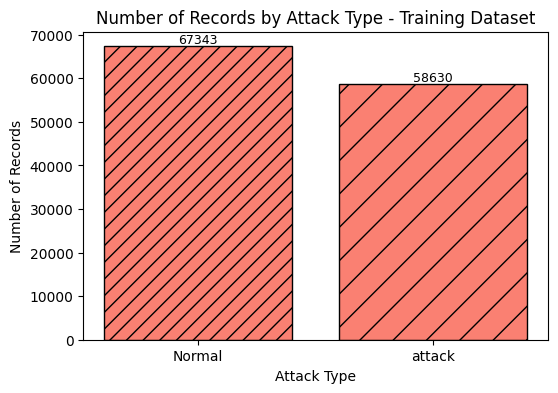

In [ ]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 10

x = ["Normal", "attack"]
y = NSL_train.attack_cat.value_counts()

plt.bar(x, y)

bars = plt.bar(x, y, color='salmon', edgecolor='black')
bars[0].set_hatch('//')
bars[1].set_hatch('/')
#bars[2].set_hatch('XX')
#bars[3].set_hatch('')
#bars[4].set_hatch('*')

for i, v in enumerate(x):
    plt.text(v, y[i], y[i],
             fontsize=9,
             color='black',
             horizontalalignment='center',
             verticalalignment='bottom')

plt.title("Number of Records by Attack Type - Training Dataset")
plt.xlabel("Attack Type")
plt.ylabel("Number of Records")

Text(0, 0.5, 'Number of Records')

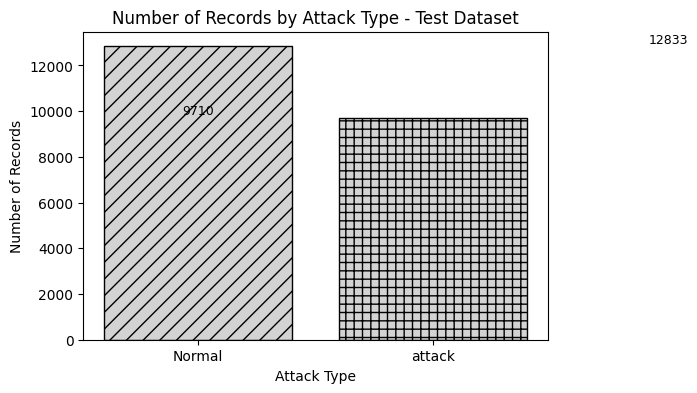

In [ ]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 10

x = ["Normal", "attack"]
y = NSL_test.attack_cat.value_counts()

plt.bar(x, y)

bars = plt.bar(x, y, color='lightgray', edgecolor='black')
bars[0].set_hatch('//')
bars[1].set_hatch('++')

plt.text("Normal", y[0], y[0],
        fontsize=9,
        color='black',
        horizontalalignment='center',
        verticalalignment='bottom')
plt.text("Dos", y[1], y[1],
        fontsize=9,
        color='black',
        horizontalalignment='center',
        verticalalignment='bottom')

plt.title("Number of Records by Attack Type - Test Dataset")
plt.xlabel("Attack Type")
plt.ylabel("Number of Records")


### Scaling

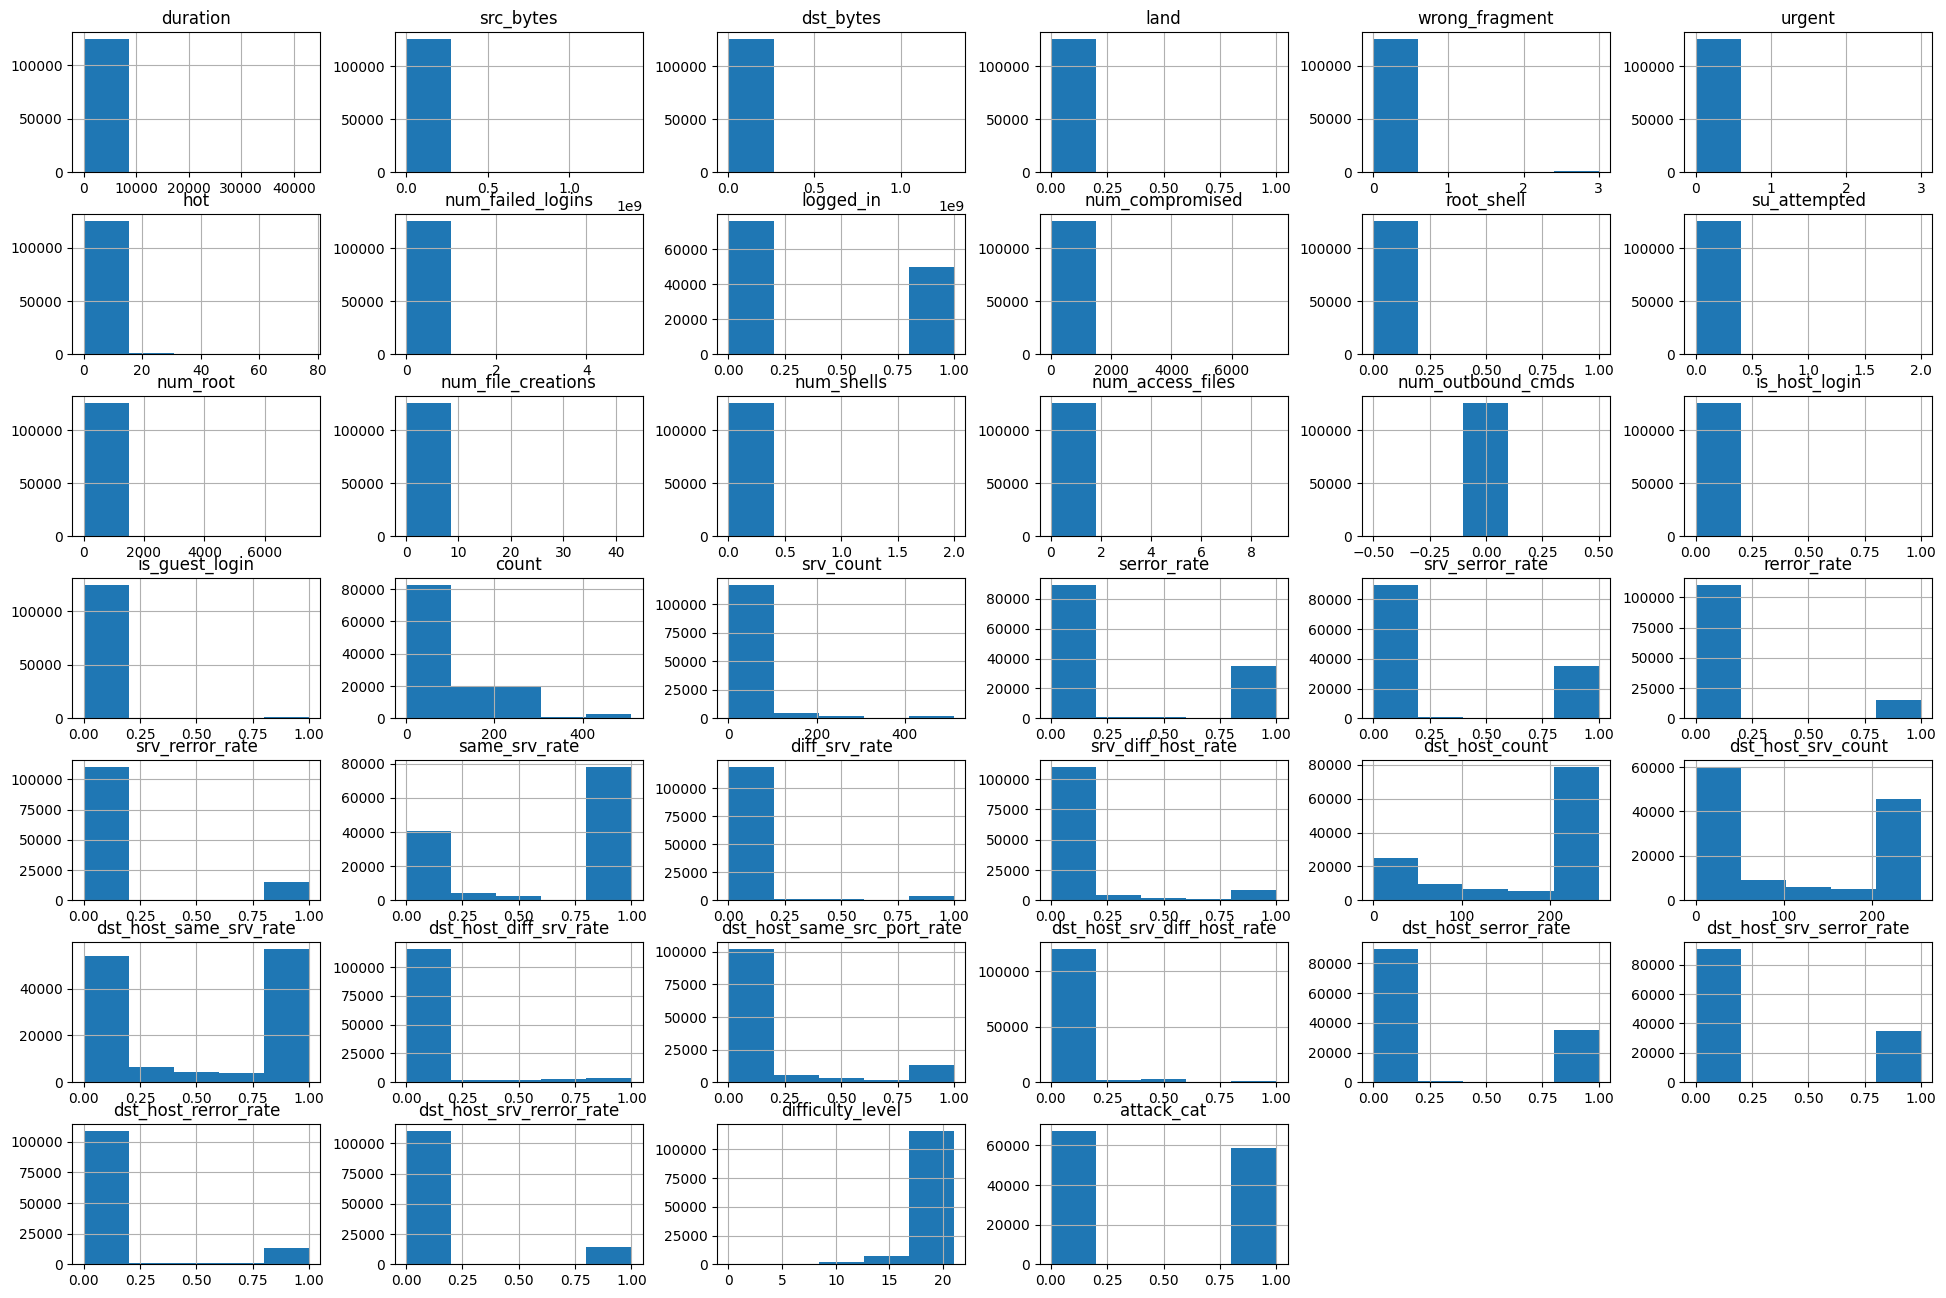

In [ ]:
NSL_train.hist(bins=5, figsize=(24,16))
plt.show()

In [ ]:
# 스케일링을 위한 Flags 종류 단순화
NSL_train.loc[NSL_train['flag'].isin(['SH', 'S3', 'S1', 'S2']), 'flag'] = 'OTH' # flag_OTH로 묶기
NSL_test.loc[NSL_test['flag'].isin(['SH', 'S3', 'S1', 'S2']), 'flag'] = 'OTH' # flag_OTH로 묶기

# 스케일링을 위한 service 종류 단순화
NSL_train.loc[~NSL_train['service'].isin(['http', 'domain_u', 'smtp', 'ftp_data', 'private', 'ftp', 'telnet', 'ecr_i', 'finger', 'z39_50', 'eco_i']), 'service'] = 'other' # 빼고는 state_othres로 묶기
NSL_test.loc[~NSL_test['service'].isin(['http', 'domain_u', 'smtp', 'ftp_data', 'private', 'ftp', 'telnet', 'ecr_i', 'finger', 'z39_50', 'eco_i']), 'service'] = 'other' # 빼고는 state_othres로 묶기

In [ ]:
NSL_train.flag.value_counts()

flag
SF        74945
S0        34851
REJ       11233
RSTR       2421
RSTO       1562
OTH         858
RSTOS0      103
Name: count, dtype: int64

In [ ]:
NSL_test.flag.value_counts()

flag
SF        14874
REJ        3850
S0         2013
RSTO        773
RSTR        669
OTH         362
RSTOS0        2
Name: count, dtype: int64

In [ ]:
NSL_train.service.value_counts()

service
http        40338
other       27029
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
eco_i        4586
ecr_i        3077
telnet       2353
finger       1767
ftp          1754
Name: count, dtype: int64

In [ ]:
NSL_test.service.value_counts()

service
http        7853
private     4774
other       3769
telnet      1626
smtp         934
domain_u     894
ftp_data     851
ecr_i        752
ftp          692
eco_i        262
finger       136
Name: count, dtype: int64

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, val_index in split.split(NSL_train, NSL_train['attack_cat']):
  train = NSL_train.loc[train_index]
  val = NSL_train.loc[val_index]

In [ ]:
nsl_train_x, nsl_train_y, nsl_val_x, nsl_val_y, nsl_test_x, nsl_test_y = get_train_val_test(train, val, NSL_test)


In [ ]:
# feature Scaling
scaler=StandardScaler()
scaler.fit(nsl_train_x)
nsl_train_x_scaled=scaler.transform(nsl_train_x)
nsl_val_x_scaled=scaler.transform(nsl_val_x)
nsl_test_x_scaled=scaler.transform(nsl_test_x)

In [ ]:
nsl_train_y_one = tf.keras.utils.to_categorical(nsl_train_y)
nsl_val_y_one = tf.keras.utils.to_categorical(nsl_val_y)
nsl_test_y_one = tf.keras.utils.to_categorical(nsl_test_y)

In [ ]:
nsl_train_y_one

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
nsl_train_x.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,service_private,service_smtp,service_telnet,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_SF
39762,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
71796,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
102489,1,1069,333,0,0,0,0,0,1,0,...,False,True,False,False,False,False,False,False,False,True
114374,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
83862,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False


from matplotlib import pyplot as plt
_df_0['duration'].plot(kind='hist', bins=20, title='duration')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['src_bytes'].plot(kind='hist', bins=20, title='src_bytes')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['dst_bytes'].plot(kind='hist', bins=20, title='dst_bytes')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['logged_in'].plot(kind='hist', bins=20, title='logged_in')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('service_other').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('service_smtp').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('flag_S0').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('flag_SF').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='duration', y='src_bytes', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='src_bytes', y='dst_bytes', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='dst_bytes', y='logged_in', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='logged_in', y='count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['land']
  ys = series['duration']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('land', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('service_other')):
  _plot_series(series, series_name, i)
  fig.legend(title='service_other', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('land')
_ = plt.ylabel('duration')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['land']
  ys = series['duration']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('land', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('service_smtp')):
  _plot_series(series, series_name, i)
  fig.legend(title='service_smtp', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('land')
_ = plt.ylabel('duration')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['land']
  ys = series['duration']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('land', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('flag_S0')):
  _plot_series(series, series_name, i)
  fig.legend(title='flag_S0', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('land')
_ = plt.ylabel('duration')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['land']
  ys = series['duration']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('land', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('flag_SF')):
  _plot_series(series, series_name, i)
  fig.legend(title='flag_SF', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('land')
_ = plt.ylabel('duration')

from matplotlib import pyplot as plt
_df_16['duration'].plot(kind='line', figsize=(8, 4), title='duration')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['src_bytes'].plot(kind='line', figsize=(8, 4), title='src_bytes')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['dst_bytes'].plot(kind='line', figsize=(8, 4), title='dst_bytes')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_19['logged_in'].plot(kind='line', figsize=(8, 4), title='logged_in')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['service_smtp'].value_counts()
    for x_label, grp in _df_20.groupby('service_other')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('service_other')
_ = plt.ylabel('service_smtp')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['flag_S0'].value_counts()
    for x_label, grp in _df_21.groupby('service_smtp')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('service_smtp')
_ = plt.ylabel('flag_S0')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['flag_SF'].value_counts()
    for x_label, grp in _df_22.groupby('flag_S0')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('flag_S0')
_ = plt.ylabel('flag_SF')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_23['service_other'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_23, x='duration', y='service_other', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['service_smtp'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='duration', y='service_smtp', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['flag_S0'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='duration', y='flag_S0', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_26['flag_SF'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_26, x='duration', y='flag_SF', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
NSL_train.loc[NSL_train['attack_cat'].isin(['normal']), 'attack_cat'] = 0
#dos
NSL_train.loc[NSL_train['attack_cat'].isin(['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'apache2', 'processtable', 'udpstorm', 'worm', 'mailbomb']), 'attack_cat'] = 1
#probe
NSL_train.loc[NSL_train['attack_cat'].isin(['satan', 'ipsweep', 'nmap', 'portsweep','mscan', 'saint']), 'attack_cat'] = 1
#u2r
NSL_train.loc[NSL_train['attack_cat'].isin(['guess_passwd', 'ftp write', 'imap', 'phf', 'multihop', 'warezclient', 'spy', 'warezmaster', 'named', 'sendmail', 'snmpguess', 'xsnoop', 'xlock', 'snmpgetattack']), 'attack_cat'] = 1
#r2l
NSL_train.loc[NSL_train['attack_cat'].isin(['buffer_overflow', 'loadmodule', 'perl', 'rootkit', 'ftp_write', 'httptunnel', 'ps', 'sqlattack', 'xterm']), 'attack_cat'] = 1



#**Models**

## **Baseline(None)**

### **SVM**

In [ ]:
start = time.time()

svm = OneVsRestClassifier(SVC(kernel="linear", gamma=1, C=5)) # 선형 커널.
svm.fit(nsl_train_x_scaled, nsl_train_y_one)

print("time :", time.time() - start)

time : 931.3311893939972


In [ ]:
nsl_val_x_scaled.shape # (37792, 59)

(37792, 59)

In [ ]:
predict(svm, nsl_val_x_scaled, nsl_val_y_one)


time : 20.94879698753357
Accuracy: 0.979%


              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98     20203
      attack       0.98      0.98      0.98     17589

   micro avg       0.98      0.98      0.98     37792
   macro avg       0.98      0.98      0.98     37792
weighted avg       0.98      0.98      0.98     37792
 samples avg       0.98      0.98      0.98     37792


roc auc value: 0.979%




array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]])

In [ ]:
predict(svm, nsl_test_x_scaled, nsl_test_y_one)

time : 12.733316898345947
Accuracy: 0.749%


              precision    recall  f1-score   support

      Normal       0.65      0.92      0.76      9710
      attack       0.91      0.62      0.74     12833

   micro avg       0.75      0.75      0.75     22543
   macro avg       0.78      0.77      0.75     22543
weighted avg       0.80      0.75      0.75     22543
 samples avg       0.75      0.75      0.75     22543


roc auc value: 0.770%




array([[0, 1],
       [0, 1],
       [1, 0],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]])

### RF

In [ ]:
params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(nsl_train_x_scaled, nsl_train_y_one)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


최적 하이퍼 파라미터:  {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9969


In [ ]:
start = time.time()

rf = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf.fit(nsl_train_x_scaled, nsl_train_y_one)

print("time :", time.time() - start)

time : 8.851689577102661


In [ ]:
predict(rf, nsl_val_x_scaled, nsl_val_y_one)

time : 0.5525848865509033
Accuracy: 0.997%


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     20203
      attack       1.00      1.00      1.00     17589

   micro avg       1.00      1.00      1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792
 samples avg       1.00      1.00      1.00     37792


roc auc value: 0.997%




array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
predict(rf, nsl_test_x_scaled, nsl_test_y_one)

time : 0.7211556434631348
Accuracy: 0.771%


              precision    recall  f1-score   support

      Normal       0.66      0.97      0.79      9710
      attack       0.97      0.62      0.76     12833

   micro avg       0.77      0.77      0.77     22543
   macro avg       0.81      0.80      0.77     22543
weighted avg       0.83      0.77      0.77     22543
 samples avg       0.77      0.77      0.77     22543


roc auc value: 0.796%




array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

###KNN


In [ ]:
start = time.time()

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(nsl_train_x_scaled, nsl_train_y_one)

print("time :", time.time() - start)

time : 0.04546475410461426


In [ ]:
predict(knn, nsl_val_x_scaled, nsl_val_y_one)

time : 36.62561869621277
Accuracy: 0.997%


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     20203
      attack       1.00      1.00      1.00     17589

   micro avg       1.00      1.00      1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792
 samples avg       1.00      1.00      1.00     37792


roc auc value: 0.997%




array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
predict(knn, nsl_test_x_scaled, nsl_test_y_one)

time : 22.894020795822144
Accuracy: 0.782%


              precision    recall  f1-score   support

      Normal       0.67      0.97      0.79      9710
      attack       0.96      0.64      0.77     12833

   micro avg       0.78      0.78      0.78     22543
   macro avg       0.82      0.80      0.78     22543
weighted avg       0.84      0.78      0.78     22543
 samples avg       0.78      0.78      0.78     22543


roc auc value: 0.804%




array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

###XGBoost

In [ ]:
# xgb = XGBClassifier()
# xg_parameters ={'max_depth' : [3,4,5,6] , 'n_estimators': [12,24,32], 'learning_rate':[0.01, 0.1], 'gamma': [0.5, 1, 2], 'random_state':42}
# grid_search_xg = GridSearchCV(xgb, param_grid = xg_parameters, scoring = 'accuracy', cv = 10)
# grid_search_xg.fit(nsl_train_x_scaled, nsl_train_y)
# best_xgb = grid_search_xg.best_estimator_
# best_xgb

In [ ]:
start=time.time()
xgb = OneVsRestClassifier(XGBClassifier(gamma=5, max_depth=12, n_estimators=32, random_state=42))
xgb.fit(nsl_train_x_scaled, nsl_train_y_one)
print("time :", time.time() - start)

#objective='multi:softprob',

time : 9.598071336746216


In [ ]:
predict(xgb, nsl_val_x_scaled, nsl_val_y_one)

time : 0.09373211860656738
Accuracy: 0.999%


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     20203
      attack       1.00      1.00      1.00     17589

   micro avg       1.00      1.00      1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792
 samples avg       1.00      1.00      1.00     37792


roc auc value: 0.999%




array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]])

In [ ]:
pred = predict(xgb, nsl_test_x_scaled, nsl_test_y_one)

time : 0.06986188888549805
Accuracy: 0.794%


              precision    recall  f1-score   support

      Normal       0.68      0.97      0.80      9710
      attack       0.97      0.66      0.78     12833

   micro avg       0.79      0.79      0.79     22543
   macro avg       0.83      0.82      0.79     22543
weighted avg       0.85      0.79      0.79     22543
 samples avg       0.79      0.79      0.79     22543


roc auc value: 0.815%




###DNN

In [ ]:
from keras.backend import dropout
model_dnn = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(59,)), # nsl_val_x_scaled.shape # (37792, 59)
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(2, activation="softmax")
])
model_dnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 59)                0         
                                                                 
 batch_normalization_3 (Bat  (None, 59)                236       
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 300)               18000     
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 batch_normalization_4 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 100)              

In [ ]:
model_dnn.compile(loss = "categorical_crossentropy",
                  optimizer = "nadam",
                  metrics=["Accuracy"]
                  )

In [ ]:
history_dnn = model_dnn.fit(nsl_train_x_scaled, nsl_train_y_one, epochs=30,
                        validation_data=(nsl_val_x_scaled, nsl_val_y_one))

Epoch 1/30
2756/2756 [==============================] - 19s 6ms/step - loss: 0.0519 - Accuracy: 0.9817 - val_loss: 0.0652 - val_Accuracy: 0.9837
Epoch 2/30
2756/2756 [==============================] - 15s 5ms/step - loss: 0.0328 - Accuracy: 0.9883 - val_loss: 0.0602 - val_Accuracy: 0.9863
Epoch 3/30
2756/2756 [==============================] - 15s 6ms/step - loss: 0.0284 - Accuracy: 0.9896 - val_loss: 0.0924 - val_Accuracy: 0.9837
Epoch 4/30
2756/2756 [==============================] - 14s 5ms/step - loss: 0.0271 - Accuracy: 0.9903 - val_loss: 0.0711 - val_Accuracy: 0.9847
Epoch 5/30
2756/2756 [==============================] - 23s 8ms/step - loss: 0.0252 - Accuracy: 0.9909 - val_loss: 0.2290 - val_Accuracy: 0.9841
Epoch 6/30
2756/2756 [==============================] - 30s 11ms/step - loss: 0.0239 - Accuracy: 0.9912 - val_loss: 0.0654 - val_Accuracy: 0.9850
Epoch 7/30
2756/2756 [==============================] - 18s 7ms/step - loss: 0.0224 - Accuracy: 0.9917 - val_loss: 0.0596 - val_A

In [ ]:
model_dnn.evaluate(nsl_test_x_scaled, nsl_test_y_one)

705/705 [==============================] - 1s 2ms/step - loss: 15.8140 - Accuracy: 0.7642


[15.814033508300781, 0.7641839981079102]

In [ ]:
predict_nn(model_dnn, nsl_val_x_scaled, nsl_val_y_one)

1181/1181 [==============================] - 2s 2ms/step
time : 2.441511631011963
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99     20203
      attack       1.00      0.99      0.99     17589

   micro avg       0.99      0.99      0.99     37792
   macro avg       0.99      0.99      0.99     37792
weighted avg       0.99      0.99      0.99     37792
 samples avg       0.99      0.99      0.99     37792

roc auc value: 0.992%




array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
predict_nn(model_dnn, nsl_test_x_scaled, nsl_test_y_one)

705/705 [==============================] - 2s 3ms/step
time : 5.2900378704071045
              precision    recall  f1-score   support

      Normal       0.66      0.93      0.77      9710
      attack       0.92      0.64      0.76     12833

   micro avg       0.76      0.76      0.76     22543
   macro avg       0.79      0.78      0.76     22543
weighted avg       0.81      0.76      0.76     22543
 samples avg       0.76      0.76      0.76     22543

roc auc value: 0.784%




array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

### **CNN**

In [ ]:
cnn = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[59, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(2, activation='softmax'),
])
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 59, 64)            512       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 29, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 29, 128)           24704     
                                                                 
 conv1d_12 (Conv1D)          (None, 29, 128)           49280     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 14, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 14, 256)          

In [ ]:
cnn.compile(loss = "categorical_crossentropy",
            optimizer = "nadam",
            metrics=["Accuracy"]
            )

In [ ]:
start=time.time()
history_cnn = cnn.fit(nsl_train_x_scaled, nsl_train_y_one, epochs=30,
                      validation_data=(nsl_val_x_scaled, nsl_val_y_one))
print("time :", time.time() - start)

Epoch 1/30
2756/2756 [==============================] - 176s 62ms/step - loss: 0.0484 - Accuracy: 0.9837 - val_loss: 0.0248 - val_Accuracy: 0.9912
Epoch 2/30
2756/2756 [==============================] - 159s 58ms/step - loss: 0.0272 - Accuracy: 0.9909 - val_loss: 0.0258 - val_Accuracy: 0.9905
Epoch 3/30
2756/2756 [==============================] - 160s 58ms/step - loss: 0.0238 - Accuracy: 0.9921 - val_loss: 0.0230 - val_Accuracy: 0.9917
Epoch 4/30
2756/2756 [==============================] - 160s 58ms/step - loss: 0.0198 - Accuracy: 0.9933 - val_loss: 0.0176 - val_Accuracy: 0.9931
Epoch 5/30
2756/2756 [==============================] - 163s 59ms/step - loss: 0.0179 - Accuracy: 0.9939 - val_loss: 0.0166 - val_Accuracy: 0.9940
Epoch 6/30
2756/2756 [==============================] - 174s 63ms/step - loss: 0.0179 - Accuracy: 0.9939 - val_loss: 0.0179 - val_Accuracy: 0.9949
Epoch 7/30
2756/2756 [==============================] - 159s 58ms/step - loss: 0.0164 - Accuracy: 0.9941 - val_loss: 0

In [ ]:
cnn.evaluate(nsl_test_x_scaled, nsl_test_y_one)

705/705 [==============================] - 13s 19ms/step - loss: 4.4915 - Accuracy: 0.7753


[4.491536617279053, 0.7752739191055298]

In [ ]:
predict_nn(cnn, nsl_val_x_scaled, nsl_val_y_one)

1181/1181 [==============================] - 22s 19ms/step
time : 41.30004286766052
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00     20203
      attack       1.00      0.99      0.99     17589

   micro avg       0.99      0.99      0.99     37792
   macro avg       1.00      0.99      0.99     37792
weighted avg       0.99      0.99      0.99     37792
 samples avg       0.99      0.99      0.99     37792

roc auc value: 0.995%




array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
predict_nn(cnn, nsl_test_x_scaled, nsl_test_y_one)

705/705 [==============================] - 14s 19ms/step
time : 20.83951711654663
              precision    recall  f1-score   support

      Normal       0.67      0.93      0.78      9710
      attack       0.92      0.66      0.77     12833

   micro avg       0.78      0.78      0.78     22543
   macro avg       0.80      0.79      0.78     22543
weighted avg       0.82      0.78      0.77     22543
 samples avg       0.78      0.78      0.78     22543

roc auc value: 0.794%




array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

## **PCA30**

In [ ]:
pca30 = PCA(n_components=30)
pca30.fit(nsl_train_x_scaled)
nsl_pca30_train = pca30.transform(nsl_train_x_scaled)
nsl_pca30_val = pca30.transform(nsl_val_x_scaled)
nsl_pca30_test = pca30.transform(nsl_test_x_scaled)

scaler.fit(nsl_pca30_train)
nsl_pca30_train_scaled=scaler.transform(nsl_pca30_train)
nsl_pca30_val_scaled=scaler.transform(nsl_pca30_val)
nsl_pca30_test_scaled=scaler.transform(nsl_pca30_test)


###**SVM**

In [ ]:
start = time.time()
rbf30_kernel_svm_clf = OneVsRestClassifier(SVC(kernel="rbf", gamma=1, C=10))
rbf30_kernel_svm_clf.fit(nsl_pca30_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

KeyboardInterrupt: 

In [ ]:
predict(rbf30_kernel_svm_clf, nsl_pca30_val_scaled, nsl_val_y_one)

In [ ]:
predict(rbf30_kernel_svm_clf, nsl_pca30_test_scaled, nsl_test_y_one)

###**RF**

In [ ]:
start=time.time()

rf30 = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf30.fit(nsl_pca30_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

In [ ]:
predict(rf30, nsl_pca30_val_scaled, nsl_val_y_one)

In [ ]:
predict(rf30, nsl_pca30_test_scaled, nsl_test_y_one)

###KNN

In [ ]:
start = time.time()

knn30 = KNeighborsClassifier(n_neighbors=3)
knn30.fit(nsl_pca30_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

In [ ]:
predict(knn30,nsl_pca30_val_scaled, nsl_val_y_one)

In [ ]:
predict(knn30,nsl_pca30_test_scaled, nsl_test_y_one)

###XGBoost

In [ ]:
start=time.time()

xgb30 =  OneVsRestClassifier(XGBClassifier(gamma=2, max_depth=6, n_estimators=32, random_state=42))
xgb30.fit(nsl_pca30_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

In [ ]:
predict(xgb30,nsl_pca30_val_scaled, nsl_val_y_one)

In [ ]:
predict(xgb30,nsl_pca30_test_scaled, nsl_test_y_one)

###DNN

In [ ]:
from keras.backend import dropout
dnn30 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(30,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])
dnn30.summary()

In [ ]:
dnn30.compile(loss="categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

In [ ]:
history_dnn30 = dnn30.fit(nsl_pca30_train_scaled, nsl_train_y_one, epochs=30,
                          validation_data=(nsl_pca30_val_scaled, nsl_val_y_one))

In [ ]:
dnn30.evaluate(nsl_pca30_test_scaled, nsl_test_y_one)

In [ ]:
predict_nn(dnn30, nsl_pca30_val_scaled, nsl_val_y_one)

In [ ]:
predict_nn(dnn30, nsl_pca30_test_scaled, nsl_test_y_one)

###**CNN**

In [ ]:
cnn30 = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[30, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
cnn30.compile(loss = "categorical_crossentropy",
              optimizer = "nadam",
              metrics=["Accuracy"]
              )

In [ ]:
start=time.time()
history_cnn = cnn30.fit(nsl_pca30_train_scaled, nsl_train_y_one, epochs=30,
                        validation_data=(nsl_pca30_val_scaled, nsl_val_y_one))
print("time :", time.time() - start)


In [ ]:
cnn30.evaluate(nsl_pca30_test_scaled, nsl_test_y_one)

In [ ]:
predict_nn(cnn30, nsl_pca30_val_scaled, nsl_val_y_one)

In [ ]:
predict_nn(cnn30, nsl_pca30_test_scaled, nsl_test_y_one)

In [ ]:
pd.DataFrame(history_cnn.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

##**PCA15**

In [ ]:
pca15 = PCA(n_components=15)
pca15.fit(nsl_train_x_scaled)
nsl_pca15_train = pca15.transform(nsl_train_x_scaled)
nsl_pca15_val = pca15.transform(nsl_val_x_scaled)
nsl_pca15_test = pca15.transform(nsl_test_x_scaled)

scaler.fit(nsl_pca15_train)
nsl_pca15_train_scaled=scaler.transform(nsl_pca15_train)
nsl_pca15_val_scaled=scaler.transform(nsl_pca15_val)
nsl_pca15_test_scaled=scaler.transform(nsl_pca15_test)

###**SVM**

In [ ]:
start = time.time()

rbf15_kernel_svm_clf = OneVsRestClassifier(SVC(kernel="rbf", gamma=1, C=10))
rbf15_kernel_svm_clf.fit(nsl_pca15_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

In [ ]:
predict(rbf15_kernel_svm_clf, nsl_pca15_val_scaled, nsl_val_y_one)

In [ ]:
predict(rbf15_kernel_svm_clf,nsl_pca15_test_scaled, nsl_test_y_one)

###RF

In [ ]:
start=time.time()
rf15 = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf15.fit(nsl_pca15_train_scaled, nsl_train_y_one)
print("time :", time.time() - start)

In [ ]:
predict(rf15,nsl_pca15_val_scaled, nsl_val_y_one)

In [ ]:
predict(rf15,nsl_pca15_test_scaled, nsl_test_y_one)

###KNN

In [ ]:
start = time.time()

knn15 = KNeighborsClassifier(n_neighbors=3)
knn15.fit(nsl_pca15_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

In [ ]:
predict(knn15,nsl_pca15_val_scaled, nsl_val_y_one)

In [ ]:
predict(knn15,nsl_pca15_test_scaled, nsl_test_y_one)

###XGBoost

In [ ]:
start=time.time()

xgb15 = OneVsRestClassifier(XGBClassifier(gamma=2, max_depth=6, n_estimators=32, random_state=42))
xgb15.fit(nsl_pca15_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

In [ ]:
predict(xgb15,nsl_pca15_val_scaled, nsl_val_y_one)

In [ ]:
predict(xgb15,nsl_pca15_test_scaled, nsl_test_y_one)

###**DNN**

In [ ]:
from keras.backend import dropout
dnn15 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(15,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])
dnn15.summary()

In [ ]:
dnn15.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
history_dnn15 = dnn15.fit(nsl_pca15_train_scaled, nsl_train_y_one, epochs=30,
                        validation_data=(nsl_pca15_val_scaled, nsl_val_y_one))

In [ ]:
dnn15.evaluate(nsl_pca15_test_scaled, nsl_test_y_one)

In [ ]:
predict_nn(dnn15, nsl_pca15_val_scaled, nsl_val_y_one)

In [ ]:
predict_nn(dnn15, nsl_pca15_test_scaled, nsl_test_y_one)

###**CNN**

In [ ]:
cnn15 = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[15, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
cnn15.compile(loss = "categorical_crossentropy",
              optimizer = "nadam",
              metrics=["Accuracy"]
              )

In [ ]:
start=time.time()
history_cnn = cnn15.fit(nsl_pca15_train_scaled, nsl_train_y_one, epochs=30,
                        validation_data=(nsl_pca15_val_scaled, nsl_val_y_one))
print("time :", time.time() - start)


In [ ]:
cnn15.evaluate(nsl_pca15_test_scaled, nsl_test_y_one)

In [ ]:
predict_nn(cnn15, nsl_pca15_val_scaled, nsl_val_y_one)

In [ ]:
predict_nn(cnn15, nsl_pca15_test_scaled, nsl_test_y_one)

##**PCA7**

In [ ]:
pca7 = PCA(n_components=7)
pca7.fit(nsl_train_x_scaled)
nsl_pca7_train = pca7.transform(nsl_train_x_scaled)
nsl_pca7_val = pca7.transform(nsl_val_x_scaled)
nsl_pca7_test = pca7.transform(nsl_test_x_scaled)

scaler.fit(nsl_pca7_train)
nsl_pca7_train_scaled=scaler.transform(nsl_pca7_train)
nsl_pca7_val_scaled=scaler.transform(nsl_pca7_val)
nsl_pca7_test_scaled=scaler.transform(nsl_pca7_test)

###**SVM**

In [ ]:
start = time.time()

rbf7_kernel_svm_clf = OneVsRestClassifier(SVC(kernel="rbf", gamma=1, C=10))
rbf7_kernel_svm_clf.fit(nsl_pca7_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

In [ ]:
predict(rbf7_kernel_svm_clf, nsl_pca7_val_scaled, nsl_val_y_one)

In [ ]:
predict(rbf7_kernel_svm_clf, nsl_pca7_test_scaled, nsl_test_y_one)

###RF

In [ ]:
start = time.time()
rf7 = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf7.fit(nsl_pca7_train_scaled, nsl_train_y_one)
print("time :", time.time() - start)

In [ ]:
predict(rf7, nsl_pca7_val_scaled, nsl_val_y_one)

In [ ]:
predict(rf7, nsl_pca7_test_scaled, nsl_test_y_one)

###KNN

In [ ]:
start = time.time()

knn7 = KNeighborsClassifier(n_neighbors=3)
knn7.fit(nsl_pca7_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

In [ ]:
predict(knn7, nsl_pca7_val_scaled, nsl_val_y_one)

In [ ]:
predict(knn7, nsl_pca7_test_scaled, nsl_test_y_one)

###XGBoost

In [ ]:
start=time.time()

xgb7 = OneVsRestClassifier(XGBClassifier(gamma=2, max_depth=6, n_estimators=32, random_state=42))
xgb7.fit(nsl_pca7_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

In [ ]:
predict(xgb7, nsl_pca7_val_scaled, nsl_val_y_one)

In [ ]:
predict(xgb7, nsl_pca7_test_scaled, nsl_test_y_one)

###DNN

In [ ]:
from keras.backend import dropout
dnn7 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(7,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])
dnn7.summary()

In [ ]:
dnn7.compile(loss="categorical_crossentropy",
            optimizer="sgd",
            metrics=["accuracy"])

In [ ]:
history_dnn7 = dnn7.fit(nsl_pca7_train_scaled, nsl_train_y_one, epochs=30,
                        validation_data=(nsl_pca7_val_scaled, nsl_val_y_one))

In [ ]:
mlp7.evaluate(nsl_pca7_test_scaled, nsl_test_y_one)

In [ ]:
predict_nn(mlp7, nsl_pca7_val_scaled, nsl_val_y_one)

In [ ]:
predict_nn(mlp7, nsl_pca7_test_scaled, nsl_test_y_one)

###**CNN**

In [ ]:
cnn7 = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[7, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
cnn7.compile(loss = "categorical_crossentropy",
            optimizer = "nadam",
            metrics=["Accuracy"]
            )

In [ ]:
start=time.time()
history_cnn = cnn7.fit(nsl_pca7_train_scaled, nsl_train_y_one, epochs=30,
                        validation_data=(nsl_pca7_val_scaled, nsl_val_y_one))
print("time :", time.time() - start)


In [ ]:
cnn7.evaluate(nsl_pca7_test_scaled, nsl_test_y_one)

In [ ]:
predict_nn(cnn7, nsl_pca7_val_scaled, nsl_val_y_one)

In [ ]:
predict_nn(cnn7, nsl_pca7_test_scaled, nsl_test_y_one)

##**PCA2**

In [ ]:
pca2 = PCA(n_components=2)
pca2.fit(nsl_train_x_scaled)
nsl_pca2_train = pca2.transform(nsl_train_x_scaled)
nsl_pca2_val = pca2.transform(nsl_val_x_scaled)
nsl_pca2_test = pca2.transform(nsl_test_x_scaled)

scaler.fit(nsl_pca2_train)
nsl_pca2_train_scaled=scaler.transform(nsl_pca2_train)
nsl_pca2_val_scaled=scaler.transform(nsl_pca2_val)
nsl_pca2_test_scaled=scaler.transform(nsl_pca2_test)

###**SVM**

In [ ]:
start = time.time()

rbf2_kernel_svm_clf = OneVsRestClassifier(SVC(kernel="rbf", gamma=1, C=10))
rbf2_kernel_svm_clf.fit(nsl_pca2_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

In [ ]:
predict(rbf2_kernel_svm_clf, nsl_pca2_val_scaled, nsl_val_y_one)

In [ ]:
predict(rbf2_kernel_svm_clf, nsl_pca2_test_scaled, nsl_test_y_one)

###RF

In [ ]:
start = time.time()
rf2 = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf2.fit(nsl_pca2_train_scaled, nsl_train_y_one)
print("time :", time.time() - start)

In [ ]:
predict(rf2, nsl_pca2_val_scaled, nsl_val_y_one)

In [ ]:
predict(rf2, nsl_pca2_test_scaled, nsl_test_y_one)

###KNN

In [ ]:
start = time.time()

knn2 = KNeighborsClassifier(n_neighbors=3)
knn2.fit(nsl_pca2_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

In [ ]:
predict(knn2, nsl_pca2_val_scaled, nsl_val_y_one)

In [ ]:
predict(knn2, nsl_pca2_test_scaled, nsl_test_y_one)

###XGBoost

In [ ]:
start=time.time()

xgb2 = OneVsRestClassifier(XGBClassifier(gamma=2, max_depth=6, n_estimators=32, random_state=42))
xgb2.fit(nsl_pca2_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

In [ ]:
predict(xgb2, nsl_pca2_val_scaled, nsl_val_y_one)

In [ ]:
predict(xgb2, nsl_pca2_test_scaled, nsl_test_y_one)

###DNN

In [ ]:
from keras.backend import dropout
dnn2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(2,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])
dnn2.summary()

In [ ]:
dnn2.compile(loss="categorical_crossentropy",
            optimizer="sgd",
            metrics=["accuracy"])

In [ ]:
history_dnn2 = dnn2.fit(nsl_pca2_train_scaled, nsl_train_y_one, epochs=30,
                        validation_data=(nsl_pca2_val_scaled, nsl_val_y_one))

In [ ]:
dnn2.evaluate(nsl_pca2_test_scaled, nsl_test_y_one)

In [ ]:
predict_nn(dnn2, nsl_pca2_val_scaled, nsl_val_y_one)

In [ ]:
predict_nn(dnn2, nsl_pca2_test_scaled, nsl_test_y_one)

###**CNN**

In [ ]:
cnn2 = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[2, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
cnn2.compile(loss = "categorical_crossentropy",
            optimizer = "nadam",
            metrics=["Accuracy"]
            )

In [ ]:
start=time.time()
history_cnn = cnn2.fit(nsl_pca2_train_scaled, nsl_train_y_one, epochs=30,
                        validation_data=(nsl_pca2_val_scaled, nsl_val_y_one))
print("time :", time.time() - start)


In [ ]:
cnn2.evaluate(nsl_pca2_test_scaled, nsl_test_y_one)

In [ ]:
predict_nn(cnn2, nsl_pca2_val_scaled, nsl_val_y_one)

In [ ]:
predict_nn(cnn2, nsl_pca2_test_scaled, nsl_test_y_one)

# **SMOTE**

In [ ]:
smote = SMOTE(random_state=42)

nsl_train_x_over, nsl_train_y_over = smote.fit_resample(nsl_train_x_scaled, nsl_train_y)
print("Before SMOTE : ", nsl_train_x.shape, nsl_train_y.shape)
print("After SMOTE :", nsl_train_x_over.shape, nsl_train_y_over.shape)


In [ ]:
nsl_train_y.value_counts()

In [ ]:
nsl_train_y_over.value_counts()

In [ ]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 10

x = ["Normal", "Dos", "Probe", "U2R", "R2L"]
y = nsl_train_y_over.value_counts()

plt.bar(x, y)

bars = plt.bar(x, y, color='lightgray', edgecolor='black')
bars[0].set_hatch('//')
bars[1].set_hatch('o')
bars[2].set_hatch('XX')
bars[3].set_hatch('.')
bars[4].set_hatch('*')

for i, v in enumerate(x):
    plt.text(v, y[i], y[i],
            fontsize=9,
            color='black',
            horizontalalignment='center',
            verticalalignment='bottom')

plt.title("Number of Records by Attack Type - Training Dataset Oversampled")
plt.xlabel("Attack Type")
plt.ylabel("Number of Records")


In [ ]:
nsl_train_y_over_one = tf.keras.utils.to_categorical(nsl_train_y_over)

## **Baseline(NONE)**

###**SVM**

In [ ]:
start = time.time()

svm_ov= OneVsRestClassifier(SVC(kernel="rbf", gamma=1, C=10))
svm_ov.fit(nsl_train_x_over, nsl_train_y_over_one)

print("time :", time.time() - start)

NameError: name 'nsl_train_x_over' is not defined

In [ ]:
predict(svm_ov, nsl_val_x_scaled, nsl_val_y_one)

In [ ]:
predict(svm_ov, nsl_test_x_scaled, nsl_test_y_one)

###**RF**

In [ ]:
start = time.time()
rf_over = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf_over.fit(nsl_train_x_over, nsl_train_y_over_one)
print("time :", time.time() - start)

In [ ]:
predict(rf_over, nsl_val_x_scaled, nsl_val_y_one)

In [ ]:
predict(rf_over, nsl_test_x_scaled, nsl_test_y_one)

###**KNN**

In [ ]:
start = time.time()

knn_over = KNeighborsClassifier(n_neighbors=3)
knn_over.fit(nsl_train_x_over, nsl_train_y_over_one)

print("time :", time.time() - start)

In [ ]:
predict(knn_over, nsl_val_x_scaled, nsl_val_y_one)

In [ ]:
predict(knn_over, nsl_test_x_scaled, nsl_test_y_one)

###**XGBoost**

In [ ]:
start=time.time()
xgb_over = OneVsRestClassifier(XGBClassifier(gamma=2, max_depth=6, n_estimators=32, random_state=42))
xgb_over.fit(nsl_train_x_over, nsl_train_y_over_one)
print("time :", time.time() - start)

In [ ]:
predict(xgb_over, nsl_val_x_scaled, nsl_val_y_one)

In [ ]:
predict(xgb_over, nsl_test_x_scaled, nsl_test_y_one)

###**DNN**

In [ ]:
from keras.backend import dropout
dnn_over = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(59,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])
dnn_over.summary()

In [ ]:
dnn_over.compile(loss = "categorical_crossentropy",
                optimizer = "nadam",
                metrics=["Accuracy"]
                )

In [ ]:
dnn_over.summary()

In [ ]:
history_over = dnn_over.fit(nsl_train_x_over, nsl_train_y_over_one, epochs=30,
                        validation_data=(nsl_val_x_scaled, nsl_val_y_one))

In [ ]:
dnn_over.evaluate(nsl_test_x_scaled, nsl_test_y_one)

In [ ]:
predict_nn(dnn_over, nsl_val_x_scaled, nsl_val_y_one)

In [ ]:
predict_nn(dnn_over, nsl_test_x_scaled, nsl_test_y_one)

###**CNN**

In [ ]:
cnn_over = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[59, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
cnn_over.compile(loss = "categorical_crossentropy",
                  optimizer = "nadam",
                  metrics=["Accuracy"]
                  )

In [ ]:
history_cnn_over = cnn_over.fit(nsl_train_x_over, nsl_train_y_over_one, epochs=30,
                        validation_data=(nsl_val_x_scaled, nsl_val_y_one))

In [ ]:
cnn_over.evaluate(nsl_test_x_scaled, nsl_test_y_one)

In [ ]:
predict_nn(cnn_over, nsl_val_x_scaled, nsl_val_y_one)

In [ ]:
predict_nn(cnn_over, nsl_test_x_scaled, nsl_test_y_one)

## **SMOTE + PCA30**

In [ ]:
pca30_over = PCA(n_components=30)
pca30_over.fit(nsl_train_x_over)
nsl_pca30_train_over = pca30_over.transform(nsl_train_x_over)
nsl_pca30_val_over = pca30_over.transform(nsl_val_x_scaled)
nsl_pca30_test_over = pca30_over.transform(nsl_test_x_scaled)

scaler.fit(nsl_pca30_train_over)
nsl_pca30_train_over_scaled=scaler.transform(nsl_pca30_train_over)
nsl_pca30_val_over_scaled=scaler.transform(nsl_pca30_val_over)
nsl_pca30_test_over_scaled=scaler.transform(nsl_pca30_test_over)

###**SVM**

In [ ]:
start = time.time()

svm30_over= SVC(kernel="rbf", gamma=1, C=10)
svm30_over.fit(nsl_pca30_train_over_scaled, nsl_train_y_over_one)

print("time :", time.time() - start)

In [ ]:
predict(svm30_over, nsl_pca30_val_over_scaled, nsl_val_y_one)

In [ ]:
predict(svm30_over, nsl_pca30_test_over_scaled, nsl_test_y_one)

###**RF**

In [ ]:
start = time.time()

rf30_over = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf30_over.fit(nsl_pca30_train_over_scaled, nsl_train_y_over_one)

print("time :", time.time() - start)

In [ ]:
predict(rf30_over, nsl_pca30_val_over_scaled, nsl_val_y_one)

In [ ]:
predict(rf30_over, nsl_pca30_test_over_scaled, nsl_test_y_one)

###**KNN**

In [ ]:
start = time.time()

knn30_over = KNeighborsClassifier(n_neighbors=3)
knn30_over.fit(nsl_pca30_train_over_scaled, nsl_train_y_over)

print("time :", time.time() - start)

In [ ]:
predict(knn30_over, nsl_pca30_val_over_scaled, nsl_val_y_one)

In [ ]:
predict(knn30_over, nsl_pca30_test_over_scaled, nsl_test_y_one)

###**XGBoost**

In [ ]:
start=time.time()
xgb30_ov = OneVsRestClassifier(XGBClassifier(gamma=2, max_depth=6, n_estimators=32, random_state=42))
xgb30_ov.fit(nsl_pca30_train_over_scaled, nsl_train_y_over_one)
print("time :", time.time() - start)

In [ ]:
predict(xgb30_ov, nsl_pca30_val_over_scaled, nsl_val_y_one)

In [ ]:
predict(xgb30_ov, nsl_pca30_test_over_scaled, nsl_test_y_one)

###**DNN**

In [ ]:
from keras.backend import dropout
dnn30_over = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(30,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])
dnn30_over.summary()

In [ ]:
dnn_over.compile(loss="sparse_categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=["accuracy"])

In [ ]:
history30_over = dnn30_over.fit(nsl_pca30_train_over_scaled, nsl_train_y_over_one, epochs=30,
                        validation_data=(nsl_pca30_val_over_scaled, nsl_val_y_o_one))

In [ ]:
dnn30_over.evaluate(nsl_pca30_test_over_scaled, nsl_test_y_one)

In [ ]:
predict_nn(dnn30_over, nsl_val_x_scaled, nsl_val_y_one)

In [ ]:
predict_nn(dnn30_over, nsl_test_x_scaled, nsl_test_y_one)

###**CNN**

In [ ]:
cnn30_over = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[30, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
cnn30_over.compile(loss = "categorical_crossentropy",
                  optimizer = "nadam",
                  metrics=["Accuracy"]
                  )

In [ ]:
history_cnn_over = cnn30_over.fit(nsl_pca30_train_over_scaled, nsl_train_y_over_one, epochs=30,
                        validation_data=(nsl_pca30_val_over_scaled, nsl_val_y_one))

In [ ]:
cnn30_over.evaluate(nsl_pca30_test_over_scaled, nsl_test_y_one)

In [ ]:
predict_nn(cnn30_over, nsl_pca30_val_scaled, nsl_val_y_one)

In [ ]:
predict_nn(cnn30_over, nsl_pca30_test_scaled, nsl_test_y_one)

##**SMOTE + PCA15**

In [ ]:
pca15_over = PCA(n_components=15)
pca15_over.fit(nsl_train_x_over)
nsl_pca15_train_over = pca15_over.transform(nsl_train_x_over)
nsl_pca15_val_over = pca15_over.transform(nsl_val_x_scaled)
nsl_pca15_test_over = pca15_over.transform(nsl_test_x_scaled)

scaler.fit(nsl_pca15_train_over)
nsl_pca15_train_over_scaled=scaler.transform(nsl_pca15_train_over)
nsl_pca15_val_over_scaled=scaler.transform(nsl_pca15_val_over)
nsl_pca15_test_over_scaled=scaler.transform(nsl_pca15_test_over)

###**SVM**

In [ ]:
start = time.time()

rbf15_ov_kernel_svm_clf = SVC(kernel="rbf", gamma=1, C=10)
rbf15_ov_kernel_svm_clf.fit(nsl_pca15_train_over_scaled, nsl_train_y_over)

print("time :", time.time() - start)

In [ ]:
predict(rbf15_ov_kernel_svm_clf, nsl_pca15_val_over_scaled, nsl_val_y)

In [ ]:
predict(rbf15_ov_kernel_svm_clf, nsl_pca15_test_over_scaled, nsl_test_y)

###**RF**

In [ ]:
start = time.time()
rf15_over = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf15_over.fit(nsl_pca15_train_over_scaled, nsl_train_y_over)
print("time :", time.time() - start)

In [ ]:
predict(rf15_over, nsl_pca15_val_over_scaled, nsl_val_y)

In [ ]:
predict(rf15_over, nsl_pca15_test_over_scaled, nsl_test_y)

###**KNN**

In [ ]:
start = time.time()

knn15_over = KNeighborsClassifier(n_neighbors=3)
knn15_over.fit(nsl_pca15_train_over_scaled, nsl_train_y_over)

print("time :", time.time() - start)

In [ ]:
predict(knn15_over, nsl_pca15_val_over_scaled, nsl_val_y)

In [ ]:
predict(knn15_over, nsl_pca15_test_over_scaled, nsl_test_y)

###**XGBoost**

In [ ]:
start=time.time()
xgb15_ov = OneVsRestClassifier(XGBClassifier(gamma=2, max_depth=6, n_estimators=32, random_state=42))
xgb15_ov.fit(nsl_pca15_train_over_scaled, nsl_train_y_over_one)
print("time :", time.time() - start)

In [ ]:
predict(xgb15_ov, nsl_pca15_val_over_scaled, nsl_val_y_one)

In [ ]:
predict(xgb15_ov, nsl_pca15_test_over_scaled, nsl_test_y_one)

###**DNN**

In [ ]:
from keras.backend import dropout
dnn15_over = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(15,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])
dnn15_over.summary()

In [ ]:
dnn15_over.compile(loss="sparse_categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=["accuracy"])

In [ ]:
history_dnn15_over = dnn15_over.fit(nsl_pca15_train_over_scaled, nsl_train_y_over, epochs=30,
                                     validation_data=(nsl_pca15_val_over_scaled, nsl_val_y))

In [ ]:
dnn15_over.evaluate(nsl_pca15_test_over_scaled, nsl_test_y)

In [ ]:
start = time.time()
pred = dnn15_over.predict(nsl_pca15_test_over_scaled)
print("time :", time.time() - start)

pred_sparse = sparse(pred)
print(classification_report(nsl_test_y_o, pred_sparse, target_names=['Normal', 'Dos', 'Probe', 'U2R', 'R2L']))

###**CNN**

In [ ]:
cnn15_over = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[15, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
cnn15_over.compile(loss = "categorical_crossentropy",
                  optimizer = "nadam",
                  metrics=["Accuracy"]
                  )

In [ ]:
history_cnn15_over = cnn15_over.fit(nsl_pca15_train_over_scaled, nsl_train_y_over_o, epochs=30,
                        validation_data=(nsl_pca15_val_over_scaled, nsl_val_y_o))

In [ ]:
cnn15_over.evaluate(nsl_pca15_test_over_scaled, nsl_test_y_o)

In [ ]:
start=time.time()
pred = cnn15_over.predict(nsl_pca15_test_over_scaled)
print("time :", time.time() - start)

pred_sparse = sparse(pred)
print(classification_report(nsl_test_y_o, pred_sparse, target_names=['Normal', 'Dos', 'Probe', 'U2R', 'R2L']))

##**SMOTE + PCA7**

In [ ]:
pca7_over = PCA(n_components=7)
pca7_over.fit(nsl_train_x_over)
nsl_pca7_train_over = pca7_over.transform(nsl_train_x_over)
nsl_pca7_val_over = pca7_over.transform(nsl_val_x_scaled)
nsl_pca7_test_over = pca7_over.transform(nsl_test_x_scaled)

scaler.fit(nsl_pca7_train_over)
nsl_pca7_train_over_scaled=scaler.transform(nsl_pca7_train_over)
nsl_pca7_val_over_scaled=scaler.transform(nsl_pca7_val_over)
nsl_pca7_test_over_scaled=scaler.transform(nsl_pca7_test_over)

###**SVM**

In [ ]:
start = time.time()

rbf7_ov_kernel_svm_clf = SVC(kernel="rbf", gamma=1, C=10)
rbf7_ov_kernel_svm_clf.fit(nsl_pca7_train_over_scaled, nsl_train_y_over)

print("time :", time.time() - start)

In [ ]:
predict(rbf7_ov_kernel_svm_clf, nsl_pca7_val_over_scaled, nsl_val_y)

In [ ]:
predict(rbf7_ov_kernel_svm_clf, nsl_pca7_test_over_scaled, nsl_test_y)

###**RF**

In [ ]:
start = time.time()
rf7_over = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf7_over.fit(nsl_pca7_train_over_scaled, nsl_train_y_over)
print("time :", time.time() - start)

In [ ]:
predict(rf7_over, nsl_pca7_val_over_scaled, nsl_val_y)

In [ ]:
predict(rf7_over, nsl_pca7_test_over_scaled, nsl_test_y)

###**KNN**

In [ ]:
start = time.time()

knn7_over = KNeighborsClassifier(n_neighbors=3)
knn7_over.fit(nsl_pca7_train_over_scaled, nsl_train_y_over)

print("time :", time.time() - start)

In [ ]:
predict(knn7_over, nsl_pca7_val_over_scaled, nsl_val_y)

In [ ]:
predict(knn7_over, nsl_pca7_test_over_scaled, nsl_test_y)

###**XGBoost**

In [ ]:
start=time.time()
xgb7_ov = OneVsRestClassifier(XGBClassifier(gamma=2, max_depth=6, n_estimators=32, random_state=42))
xgb7_ov.fit(nsl_pca7_train_over_scaled, nsl_train_y_over_one)
print("time :", time.time() - start)

In [ ]:
predict(xgb7_ov, nsl_pca7_val_over_scaled, nsl_val_y_one)

In [ ]:
predict(xgb7_ov, nsl_pca7_test_over_scaled, nsl_test_y_one)

###**DNN**

In [ ]:
from keras.backend import dropout
dnn7_over = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(7,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])
dnn7_over.summary()

In [ ]:
history_dnn7_over = dnn7_over.fit(nsl_pca7_train_over_scaled, nsl_train_y_over, epochs=50,
                        validation_data=(nsl_pca7_val_over_scaled, nsl_val_y_o))

In [ ]:
dnn7_over.evaluate(nsl_pca7_test_over_scaled, nsl_test_y_o)

In [ ]:
pred = dnn7_over.predict(nsl_pca7_test_over_scaled)
pred_sparse = sparse(pred)
print(classification_report(nsl_test_y_o, pred_sparse, target_names=['Normal', 'Dos', 'Probe', 'U2R', 'R2L']))

###**CNN**

In [ ]:
cnn7_over = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[7, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
cnn7_over.compile(loss = "categorical_crossentropy",
                  optimizer = "nadam",
                  metrics=["Accuracy"]
                  )

In [ ]:
history_cnn7_over = cnn7_over.fit(nsl_pca7_train_over, nsl_pca7_train_y_over_o, epochs=30,
                        validation_data=(nsl_pca7_val_x_scaled, nsl_pca7_val_y_o))

In [ ]:
cnn7_over.evaluate(nsl_pca7_test_x_scaled, nsl_pca7_test_y_o)

In [ ]:
pred = cnn7_over.predict(nsl_pca7_test_x_scaled)
pred_sparse = sparse(pred)
print(classification_report(nsl_pca7_test_y_o, pred_sparse, target_names=['Normal', 'Dos', 'Probe', 'U2R', 'R2L']))

##**SMOTE + PCA2**

In [ ]:
pca2_over = PCA(n_components=2)
pca2_over.fit(nsl_train_x_over)
nsl_pca2_train_over = pca2_over.transform(nsl_train_x_over)
nsl_pca2_val_over = pca2_over.transform(nsl_val_x_scaled)
nsl_pca2_test_over = pca2_over.transform(nsl_test_x_scaled)

scaler.fit(nsl_pca2_train_over)
nsl_pca2_train_over_scaled=scaler.transform(nsl_pca2_train_over)
nsl_pca2_val_over_scaled=scaler.transform(nsl_pca2_val_over)
nsl_pca2_test_over_scaled=scaler.transform(nsl_pca2_test_over)

###**SVM**

In [ ]:
start = time.time()

rbf2_ov_kernel_svm_clf = SVC(kernel="rbf", gamma=1, C=10)
rbf2_ov_kernel_svm_clf.fit(nsl_pca2_train_over_scaled, nsl_train_y_over)

print("time :", time.time() - start)

In [ ]:
predict(rbf2_ov_kernel_svm_clf, nsl_pca2_val_over_scaled, nsl_val_y)

In [ ]:
predict(rbf2_ov_kernel_svm_clf, nsl_pca2_test_over_scaled, nsl_test_y)

###**RF**

In [ ]:
start = time.time()
rf2_over = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf2_over.fit(nsl_pca2_train_over_scaled, nsl_train_y_over)
print("time :", time.time() - start)

In [ ]:
predict(rf2_over, nsl_pca2_val_over_scaled, nsl_val_y)

In [ ]:
predict(rf2_over, nsl_pca2_test_over_scaled, nsl_test_y)

###**KNN**

In [ ]:
start = time.time()

knn2_over = KNeighborsClassifier(n_neighbors=3)
knn2_over.fit(nsl_pca2_train_over_scaled, nsl_train_y_over)

print("time :", time.time() - start)

In [ ]:
predict(knn2_over, nsl_pca2_val_over_scaled, nsl_val_y)

In [ ]:
predict(knn2_over, nsl_pca2_test_over_scaled, nsl_test_y)

###**XGBoost**

In [ ]:
start=time.time()
xgb2_ov = OneVsRestClassifier(XGBClassifier(gamma=2, max_depth=6, n_estimators=32, random_state=42))
xgb2_ov.fit(nsl_pca2_train_over_scaled, nsl_train_y_over_one)
print("time :", time.time() - start)

In [ ]:
predict(xgb2_ov, nsl_pca2_val_over_scaled, nsl_val_y_one)

In [ ]:
predict(xgb2_ov, nsl_pca2_test_over_scaled, nsl_test_y_one)

###**DNN**

In [ ]:
from keras.backend import dropout
dnn2_over = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(2,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])
dnn2_over.summary()

In [ ]:
history_dnn2_over = dnn2_over.fit(nsl_pca2_train_over_scaled, nsl_train_y_over, epochs=30,
                                  validation_data=(nsl_pca2_val_over_scaled, nsl_val_y_one))

In [ ]:
dnn2_over.evaluate(nsl_pca2_test_over_scaled, nsl_test_y_one)

In [ ]:
pred = dnn2_over.predict(nsl_pca2_test_over_scaled)
pred_sparse = sparse(pred)
print(classification_report(nsl_test_y_one, pred_sparse, target_names=['Normal', 'Dos', 'Probe', 'U2R', 'R2L']))

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(history2_over.history['loss'], label='Train loss')
plt.plot(history2_over.history['val_loss'], label='Validation loss')

plt.title("Loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(history2_over.history['accuracy'], label='Train accuracy')
plt.plot(history2_over.history['val_accuracy'], label='Validation accuracy')

plt.title("accuracy")
plt.legend()
plt.show()

###**CNN**

In [ ]:
cnn2_over = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[2, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
cnn2_over.compile(loss = "categorical_crossentropy",
                  optimizer = "nadam",
                  metrics=["Accuracy"]
                  )

In [ ]:
history_cnn2_over = cnn2_over.fit(nsl_pca2_train_over, nsl_pca2_train_y_over_one, epochs=30,
                        validation_data=(nsl_pca2_val_x_scaled, nsl_pca2_val_y_one))

In [ ]:
cnn2_over.evaluate(nsl_pca2_test_x_scaled, nsl_pca2_test_y_one)

In [ ]:
pred = cnn2_over.predict(nsl_pca2_test_x_scaled)
pred_sparse = sparse(pred)
print(classification_report(nsl_pca2_test_y_one, pred_sparse, target_names=['Normal', 'Dos', 'Probe', 'U2R', 'R2L']))